In [1]:
#Calculates the number of Clenches in individual .csv file of EEG data caused by fluctuations in Electric Potential.

In [2]:
from scipy import fft, arange, signal
from scipy.special import logit, expit
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import csv
import pandas as pd
from ttictoc import TicToc
#----------------------
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split
#---------------------RF HP-f(x) & CV---------------
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
EEG_FOLDER = "../../data/Clench/Batch_Tests"

In [4]:
def find_files(PATH, ext):
    """
    Finds all the files in a particular directory. Return only .csv files.
    """
    files = []
    for r, d, f in os.walk(PATH):
        for file in f:
            if ext in file:
                files.append(os.path.join(r, file).replace("\\","/"))
    return files

In [5]:
def remove_meta_data(PATH):
    """
    Return:
    1. Changes in Electric potential based on Unix timestamp from
        the 5 channels of the Emotiv headset. 2 channels from the Frontal Lobe, 
        1 channel from the parietal lobe, and 2 from temporal lobe.
    2. Pandas Dataframe of the data reflected from (1).
    """
    reader = csv.reader(open(PATH, "rt"), delimiter='\t')
    i = 0
    one_file_data = []
    for line in reader:
        if(i > 0):
            one_file_data.append(line)
        i += 1
    one_file_data = np.array(one_file_data)
    columns = one_file_data[0][0].split(",")[3:8]
    row_data = []
    for rows in one_file_data[1:]:
        dtx = rows[0].split(",")[3:8]
        cont = []
        for x in dtx:
            cont.append(float(x))
        row_data.append(cont)
    dataframe = pd.DataFrame(row_data, columns=columns)
    return np.array(row_data), dataframe

In [6]:
def data_DF_dir(list_PATH):
    """
    Returns all the data from a given set of path files and its associated pandas dataframe object.
    """
    raw_data = []
    dataframes = []
    for file in list_PATH:
        rd, dfob = remove_meta_data(file)
        raw_data.append(rd)
        dataframes.append(dfob)
    return raw_data, dataframes

In [7]:
def count_peaks_validation(peaks, x, threshold_vertical):
    count = 0
    for states in peaks:
        if(states > threshold_vertical):
            count += 1
    plt.plot(x)
    plt.xlabel("Time (sample_rate (128) per second expansion)")
    plt.ylabel("Amplitude")
    plt.title("Time Domain Chart of Peak count (One-Sided f(x))", y=1.08)
    return count

In [8]:
def ease(index, distance, start_index, threshold_vertical, height, width):
    dataCV = []
    peakCV = []
    for i in range(0, 5):
        x = bci_data[index].T[i][start_index:]
        x = abs(x - np.average(x))  # biasing.
        peaks, props = signal.find_peaks(x, distance=distance, height=height, width=width)
        count = count_peaks_validation(peaks, x, threshold_vertical)
        dataCV.append(count)
        peakCV.append(peaks)
    count = round(np.array(dataCV).mean())
    return friendly_name[index], count, peakCV

In [9]:
files = find_files(EEG_FOLDER, ".csv")

In [10]:
bci_data, bci_df = data_DF_dir(files)

In [11]:
friendly_name = [x.split("/")[-1].split("_")[0] for x in files]

In [12]:
ind = 1

In [13]:
files[ind]

'../../data/Clench/Batch_Tests/1plus1usman_test_03.01.20_17.03.06.bp.csv'

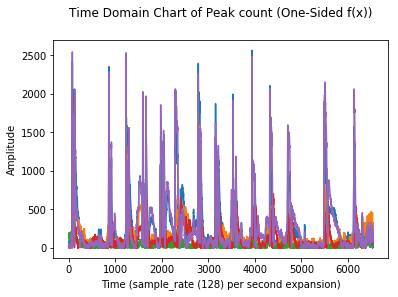

In [14]:
_,t, prp = ease(ind, 309, 384, 50, 200, 1)

In [16]:
def calc_difference(art):
    diar = []
    for arr in art:
        opA = 0
        opB = 0
        diff_arr = []
        for i in arr:
            opB = i
            diff_arr.append(opB - opA)
            opA = i
        diff_arr = np.array(diff_arr)
        diar.append(diff_arr)
    return diar

In [17]:
diff = calc_difference(prp)

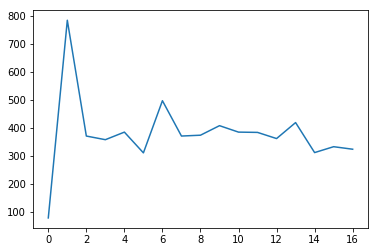

In [18]:
plt.plot(diff[0])

In [21]:
dex = 2

In [22]:
units = 0
opcodes = []
for i in range(len(diff[dex])):
    if(diff[dex][i] <= 700):
        units += 1
    elif(diff[dex][i] > 700):
        opcodes.append(units)
        units = 0
if(units > 0):    
    opcodes.append(units)

In [24]:
def get_result(count):
    opA = ''
    opB = ''
    operation = ['+','-','*','/']
    result = 0

    check = False
    for x in count:
        x = int(x)
        if(x < 10):
            if(check == True):
                opB += str(x)
            else:
                opA += str(x)
        else:
            operation = operation[int(x%10)]
            check = True
    
    opA = int(opA)
    if(check):
        opB = int(opB)
    else:
        opB = 0
        result = opA
        operation = None
    
    if(operation == '+'):
        result = opA + opB
    elif(operation == '-'):
        result = opA - opB
    elif(operation == '*'):
        result = opA * opB
    elif(operation == '/'):
        result = opA / opB
    return opA, operation, opB, result

In [25]:
opA, operation, opB, result = get_result(opcodes)

In [26]:
opA, operation, opB, result

(1, '+', 1, 2)